In [ ]:
#Import libraries
import os
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
print("Libraries imported")

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported


In [ ]:
#Import data to create random student profiles
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

def load_final_careers():
    path = os.path.join(BASE_DIR, '..', 'datasets', 'final_careers.csv')
    return pd.read_csv(path)

def load_initial_skills():
    path = os.path.join(BASE_DIR, '..', 'datasets', 'renamed_careers.csv') 
    return pd.read_csv(path)

final_careers = load_final_careers()
renamed_careers = load_initial_skills()
skills_embedding = np.load(os.path.join(BASE_DIR, '..', 'datasets', 'final_career_embeddings.npy'))

print("Data imported")

Data imported


In [ ]:
#Creating test student profiles
np.random.seed(20)

student_skills=renamed_careers["Skills"].unique()
student_domains=final_careers["Domain of Interest"].unique()

def create_profiles():
    skills = np.random.choice(student_skills, 7, replace=False)
    domain = np.random.choice(student_domains)
    return {'Skills': skills, 'Domain of Interest': domain}

student_profiles = [create_profiles() for _ in range(100)]
students = pd.DataFrame(student_profiles)

print(students.shape)

(100, 2)


In [ ]:
#Run model for further use
model = SentenceTransformer("all-MiniLM-L6-v2")
print("Model run succesfully")

Model run succesfully


Overall average similarity score (Version A): 39.80%


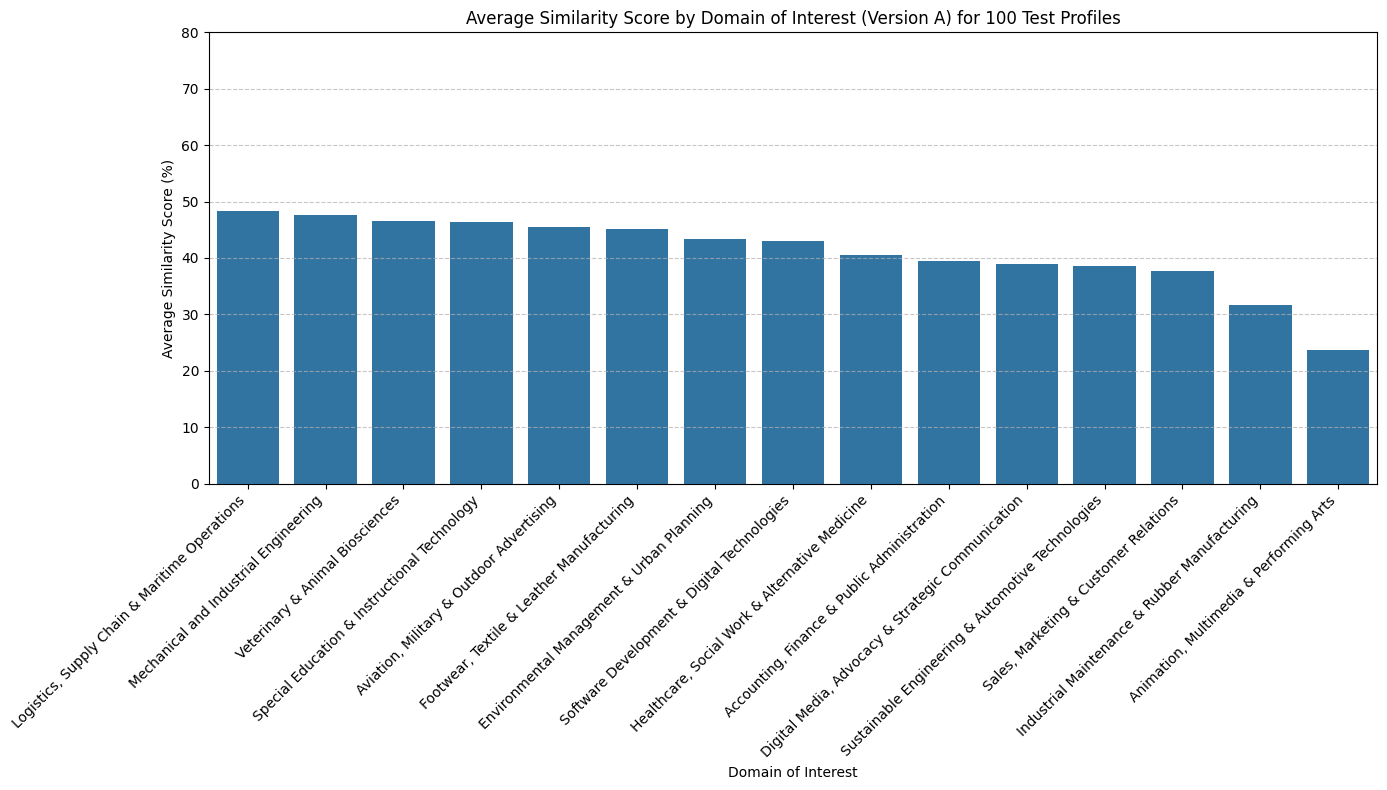

In [ ]:
#Version A

#Recommender test function
def Frontend_A_test(domain, skills, recommended_career, embeddings):
    filtered_careers = recommended_career[recommended_career["Domain of Interest"] == domain]
    filtered_indices = filtered_careers.index
    filtered_embeddings = embeddings[filtered_indices]

    skills_string = " ".join(skills)
    user_skills_emb = model.encode([skills_string])

    similarities = cosine_similarity(user_skills_emb, filtered_embeddings)[0]
    top_indices = similarities.argsort()[::-1][:3]

    recommendations = []
    for index in top_indices:
        career = filtered_careers.iloc[index]["Career Path"]
        score = similarities[index] * 100
        recommendations.append((career, score))

    return recommendations

#Overall similarity scores
all_scores = []

for _, row in students.iterrows():
    output = Frontend_A_test(row["Domain of Interest"],row["Skills"],final_careers,skills_embedding)

    for _, score in output:
        all_scores.append(score)

overall_avg_A = sum(all_scores) / len(all_scores)
print(f"Overall average similarity score (Version A): {overall_avg_A:.2f}%")

#Similarity scores by domain
domain_similarity_scores = defaultdict(list)

for _, row in students.iterrows():
    domain = row["Domain of Interest"]
    skills = row["Skills"]
    output = Frontend_A_test(domain, skills, final_careers, skills_embedding)

    for _, score in output:
        domain_similarity_scores[domain].append(score)

average_by_domain = pd.DataFrame([{"Domain": domain, "Average Score": sum(scores) / len(scores)}
    for domain, scores in domain_similarity_scores.items()])

average_by_domain_sorted = average_by_domain.sort_values(by="Average Score", ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(data=average_by_domain_sorted, x="Domain", y="Average Score")
plt.title("Average Similarity Score by Domain of Interest (Version A) for 100 Test Profiles")
plt.ylabel("Average Similarity Score (%)")
plt.xlabel("Domain of Interest")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 80)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Overall average similarity score (Version B): 54.82%


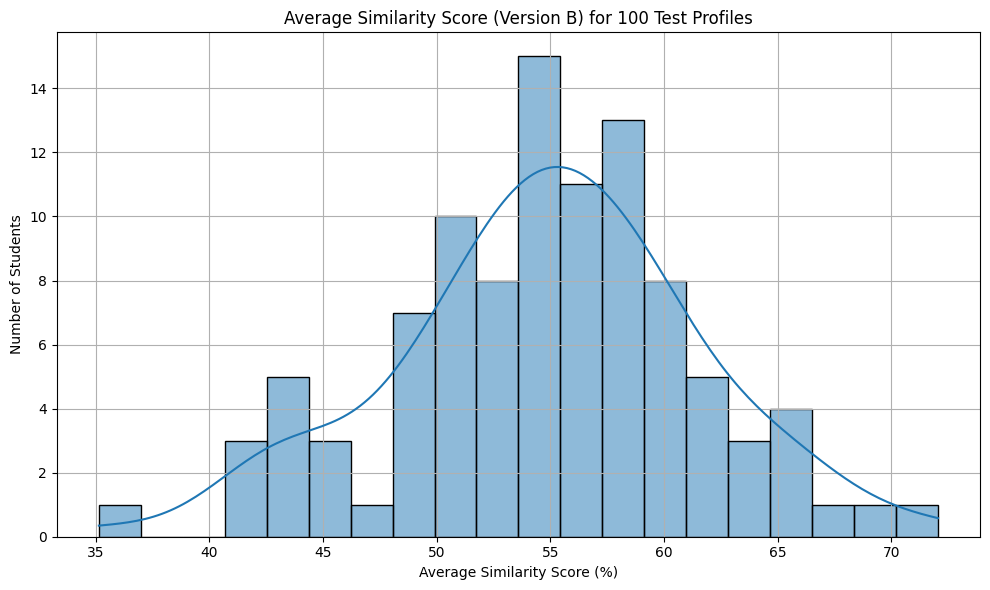

In [ ]:
#Version B

#Recommender test function
def Frontend_B_test(skills, recommended_careers, embeddings):
    skills_string = " ".join(skills)
    user_skills_emb = model.encode([skills_string])
    similarities = cosine_similarity(user_skills_emb, embeddings)[0]
    top_indices = similarities.argsort()[::-1][:3]

    recommendations = []
    for index in top_indices:
        career = recommended_careers.iloc[index]["Career Path"]
        score = similarities[index] * 100
        recommendations.append((career, score))
    return recommendations

#Overall similarity scores
total_scores = []

for i, row in students.iterrows():
    output = Frontend_B_test(row["Skills"], final_careers, skills_embedding)
    
    for _, score in output:
        total_scores.append(score)
    
overall_avg_B = sum(total_scores) / len(total_scores)
print(f"Overall average similarity score (Version B): {overall_avg_B:.2f}%")

#Similarity scores distribution for all 100 test profiles 
average_scores_per_student = []

for _, row in students.iterrows():
    skills = row["Skills"]
    output = Frontend_B_test(skills, final_careers, skills_embedding)
    scores = [score for _, score in output]
    average_score = sum(scores) / len(scores)
    average_scores_per_student.append(average_score)

average_by_profile = pd.DataFrame({"Average Similarity Score": average_scores_per_student})

plt.figure(figsize=(10, 6))
sns.histplot(average_by_profile["Average Similarity Score"], bins=20, kde=True)
plt.title("Average Similarity Score (Version B) for 100 Test Profiles")
plt.xlabel("Average Similarity Score (%)")
plt.ylabel("Number of Students")
plt.grid(True)
plt.tight_layout()
plt.show()

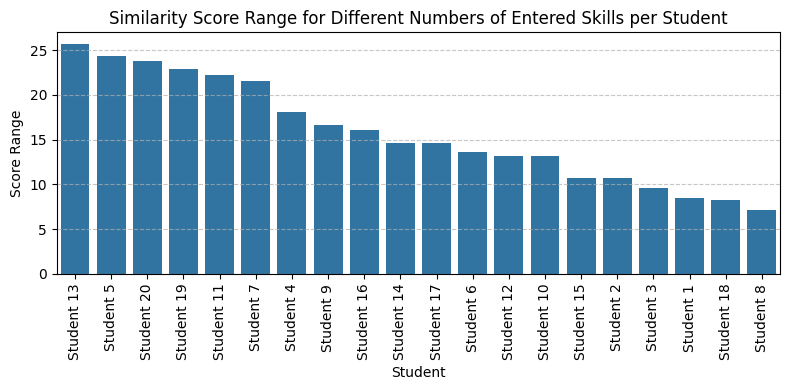

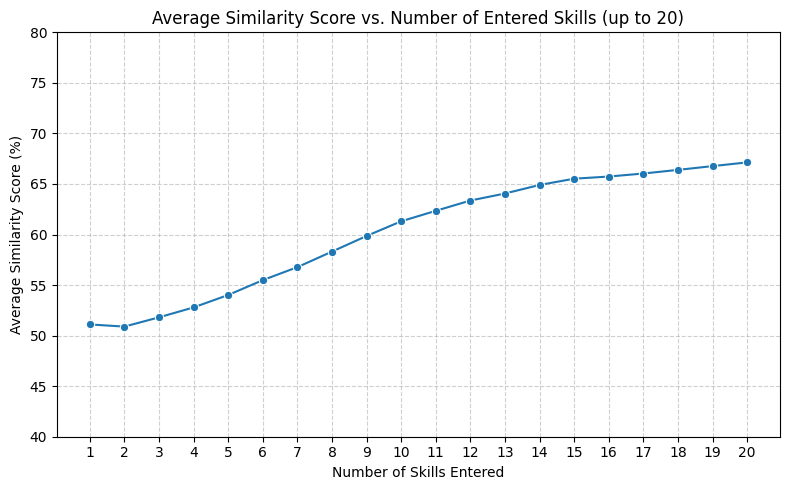

In [ ]:
#Number of skills impact analysis

#Similarity score ranges for 20 random test profiles for different number of entered skills (1-7)
sampled_students = students.sample(n=20, random_state=10).reset_index(drop=True)

ranges = []

for index, row in sampled_students.iterrows():
    full_skills = row["Skills"]
    student_id = f"Student {index+1}"

    for k in range(1, 8):
        selected_skills = full_skills[:k]
        skills_string = " ".join(selected_skills)
        user_emb = model.encode([skills_string])

        similarities= cosine_similarity(user_emb, skills_embedding)[0]
        top_score= similarities.max()*100

        ranges.append({"Student": student_id,"Number of Skills": k,"Similarity Score": top_score})

ranges_frame = pd.DataFrame(ranges)

score_ranges = (ranges_frame.groupby("Student")["Similarity Score"].agg(["min", "max"]).assign(Range=lambda x: x["max"] - x["min"]).reset_index())

plt.figure(figsize=(8, 4))
sns.barplot(data=score_ranges.sort_values("Range", ascending=False), x="Student", y="Range")
plt.title("Similarity Score Range for Different Numbers of Entered Skills per Student")
plt.xticks(rotation=90)
plt.ylabel("Score Range")
plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


#Project number of skills needed to improve score (up to 20)
np.random.seed(10)

student_profiles_2 = [{'Skills': np.random.choice(student_skills, 20, replace=False), 'Domain of Interest': np.random.choice(student_domains)}
    for _ in range(100)]

students_2 = pd.DataFrame(student_profiles_2)

scores_by_skill_count = defaultdict(list)

for _, row in students_2.iterrows():
    full_skills = row["Skills"]

    for k in range(1, 21):
        skills_string = " ".join(full_skills[:k])
        user_emb = model.encode([skills_string])
        top_score = cosine_similarity(user_emb, skills_embedding)[0].max()*100
        scores_by_skill_count[k].append(top_score)

average_scores_frame = pd.DataFrame({
    "Num Skills": list(scores_by_skill_count.keys()),
    "Average Similarity Score": [sum(scores) / len(scores) for scores in scores_by_skill_count.values()]})

plt.figure(figsize=(8, 5))
sns.lineplot(data=average_scores_frame, x="Num Skills", y="Average Similarity Score", marker="o")
plt.title("Average Similarity Score vs. Number of Entered Skills (up to 20)")
plt.xlabel("Number of Skills Entered")
plt.xticks(range(1, 21)) 
plt.ylabel("Average Similarity Score (%)")
plt.ylim(40, 80)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()